<a href="https://colab.research.google.com/github/UAC-DavidSB/CNNs/blob/main/SVHN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🟢 Dispositivo usado: cuda


100%|██████████| 182M/182M [00:16<00:00, 11.1MB/s]
100%|██████████| 64.3M/64.3M [00:10<00:00, 6.13MB/s]


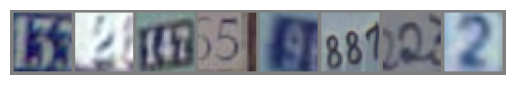

Ejemplo de etiquetas: [3 2 4 5 9 8 2 2]
SVHN_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Época [1/10] 🧩 Pérdida Entrenamiento: 0.8668 | Pérdida Test: 0.4627 | Precisión: 86.76%
Época [2/10] 🧩 Pérdida Entrenamiento: 0.4320 | Pérdida Test: 0.3784 | Precisión: 88.66%
Época [3/10] 🧩 Pérdi

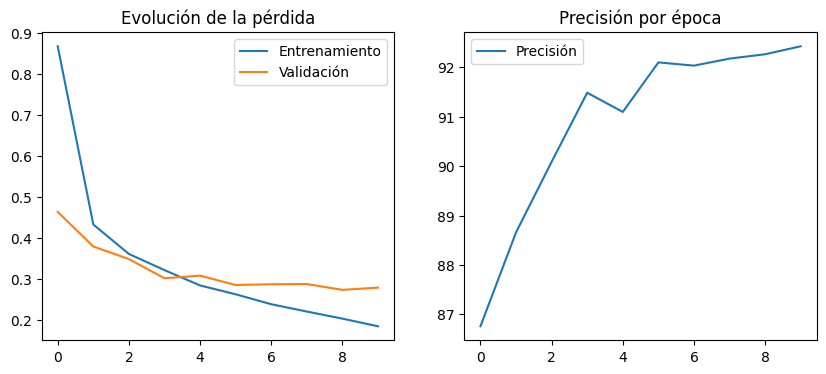

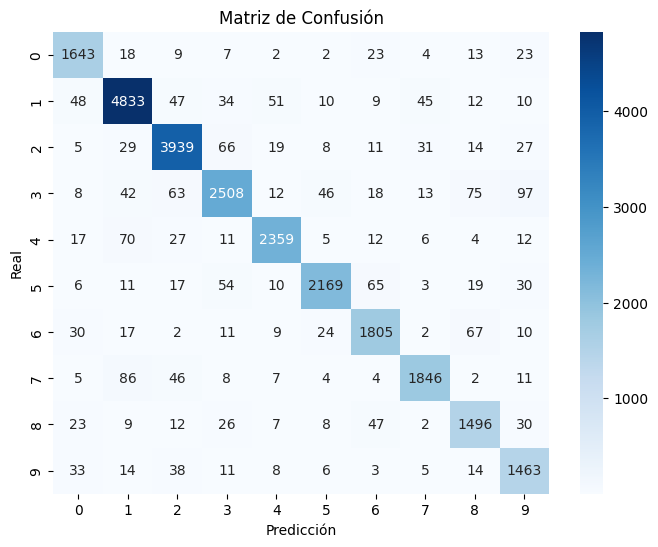


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1744
           1       0.94      0.95      0.95      5099
           2       0.94      0.95      0.94      4149
           3       0.92      0.87      0.89      2882
           4       0.95      0.93      0.94      2523
           5       0.95      0.91      0.93      2384
           6       0.90      0.91      0.91      1977
           7       0.94      0.91      0.93      2019
           8       0.87      0.90      0.89      1660
           9       0.85      0.92      0.88      1595

    accuracy                           0.92     26032
   macro avg       0.92      0.92      0.92     26032
weighted avg       0.92      0.92      0.92     26032


📸 Sube imágenes para probar el modelo. (Ej. fotos de números o recortes de SVHN)
Se mantendrá en bucle hasta que canceles manualmente (Ctrl + C).


Saving depositphotos_352888766-stock-photo-house-number-162-sign-wooden.jpg to depositphotos_352888766-stock-photo-house-number-162-sign-wooden.jpg


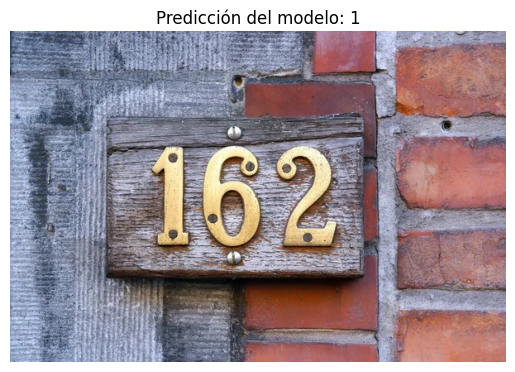

🔁 Puedes subir otra imagen para seguir probando.


Saving ceramic-house-number-forty-three-260nw-477467044.webp to ceramic-house-number-forty-three-260nw-477467044.webp


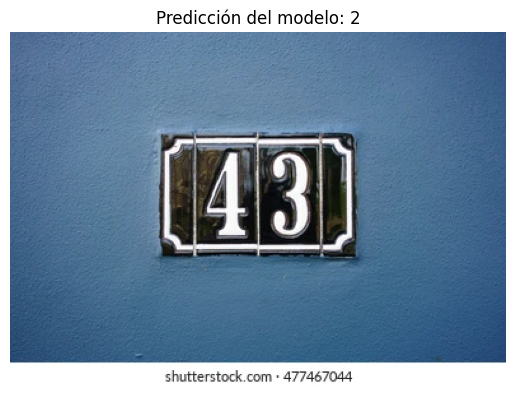

🔁 Puedes subir otra imagen para seguir probando.


Saving house-number-five-hundred-forty-260nw-1087793171.webp to house-number-five-hundred-forty-260nw-1087793171.webp
Saving ceramic-house-number-forty-three-260nw-477467044.webp to ceramic-house-number-forty-three-260nw-477467044 (1).webp
Saving depositphotos_352888766-stock-photo-house-number-162-sign-wooden.jpg to depositphotos_352888766-stock-photo-house-number-162-sign-wooden (1).jpg
Saving OIP.webp to OIP.webp
Saving SVHN.ipynb to SVHN.ipynb
Saving notebookd26488d279.ipynb to notebookd26488d279.ipynb
Saving notebook3aab2a2883.ipynb to notebook3aab2a2883.ipynb
Saving notebook1c48f0b0f6.ipynb to notebook1c48f0b0f6.ipynb


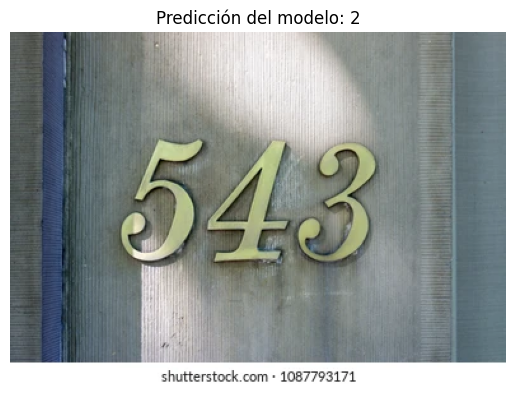

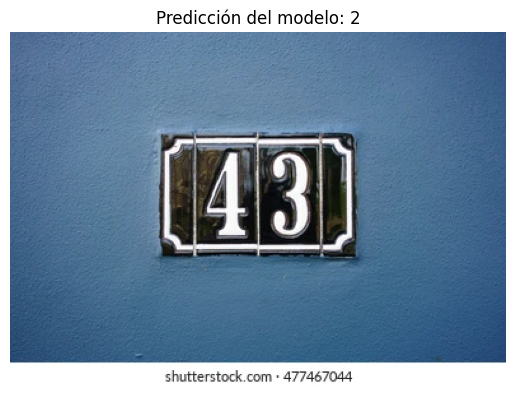

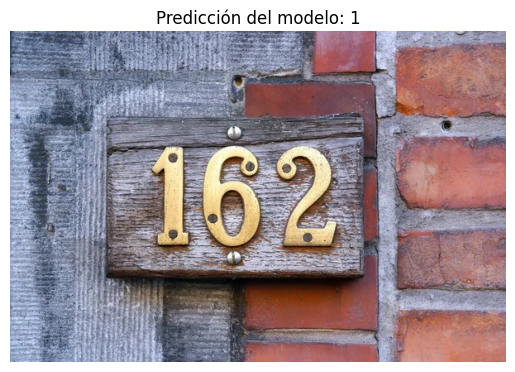

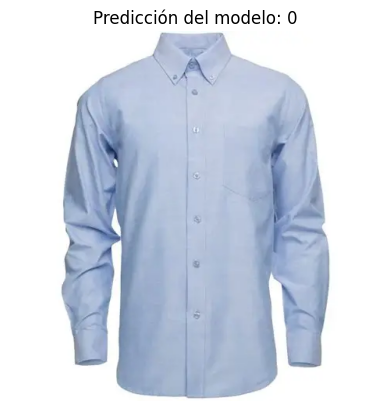

UnidentifiedImageError: cannot identify image file 'SVHN.ipynb'

In [1]:
# ======================================================
# 🧠 CNN - Street View House Numbers (SVHN)
# ======================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import files
from PIL import Image

# ======================================================
# 1️⃣ Configuración del entorno
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🟢 Dispositivo usado: {device}")

# ======================================================
# 2️⃣ Preprocesamiento de datos
# ======================================================
# Normalización centrada en 0, con desviación 0.5 en cada canal
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = SVHN(root='./data', split='train', download=True, transform=transform)
testset = SVHN(root='./data', split='test', download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# ======================================================
# 3️⃣ Visualización de ejemplos
# ======================================================
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print("Ejemplo de etiquetas:", labels[:8].numpy())

# ======================================================
# 4️⃣ Arquitectura CNN
# ======================================================
"""
Elección de funciones y capas:
- Conv2D: extrae características espaciales locales.
- ReLU: se usa porque es rápida, evita saturación y facilita el aprendizaje.
- BatchNorm: estabiliza las activaciones (acelera convergencia).
- MaxPool: reduce dimensionalidad y conserva patrones importantes.
- Dropout: evita sobreajuste.
"""

class SVHN_CNN(nn.Module):
    def __init__(self):
        super(SVHN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Cada capa conv → BN → ReLU → Pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SVHN_CNN().to(device)
print(model)

# ======================================================
# 5️⃣ Entrenamiento
# ======================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, test_accs = [], [], []
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # --- Evaluación ---
    model.eval()
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_losses.append(test_loss / len(testloader))
    test_accs.append(acc)

    print(f"Época [{epoch+1}/{epochs}] 🧩 "
          f"Pérdida Entrenamiento: {train_losses[-1]:.4f} | "
          f"Pérdida Test: {test_losses[-1]:.4f} | "
          f"Precisión: {acc:.2f}%")

print("\n✅ Entrenamiento finalizado.")

# ======================================================
# 6️⃣ Métricas y evaluación
# ======================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Entrenamiento')
plt.plot(test_losses, label='Validación')
plt.title("Evolución de la pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accs, label='Precisión')
plt.title("Precisión por época")
plt.legend()
plt.show()

# =============================
# Matriz de confusión
# =============================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Reporte por clase
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

# ======================================================
# 7️⃣ Prueba interactiva en bucle
# ======================================================
print("\n📸 Sube imágenes para probar el modelo. (Ej. fotos de números o recortes de SVHN)")
print("Se mantendrá en bucle hasta que canceles manualmente (Ctrl + C).")

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

while True:
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = Image.open(filename).convert('RGB')
        img_t = transform_test(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_t)
            _, pred = torch.max(output, 1)

        plt.imshow(img)
        plt.title(f"Predicción del modelo: {pred.item()}")
        plt.axis('off')
        plt.show()
    print("🔁 Puedes subir otra imagen para seguir probando.")
